In [2]:
import numpy as np
from matplotlib import pyplot as plt
import SimpleITK as sitk
import os

In [ ]:
## Function to register 3D MRI volumes to 3D CT volumes. Based on knowledge that provided masks are made on the CT images. Write registered MRI volumes to "/HaN-Seg Registered/".
## @Inputs:
##       None
## @Outputs: 
##       None
def register():
    output_dir = "../HaN-Seg Registered"

    for i in range(1, 43):
        case_num = f"{i:02d}"
        filepath_ct = f"../HaN-Seg/set_1/case_{case_num}/case_{case_num}_IMG_CT.nrrd"
        filepath_mri = f"../HaN-Seg/set_1/case_{case_num}/case_{case_num}_IMG_MR_T1.nrrd"
        ct = sitk.ReadImage(filepath_ct, sitk.sitkFloat32)
        mri = sitk.ReadImage(filepath_mri, sitk.sitkFloat32)
        
        # Registers the MRI image to the CT image
        mri_registered = register_helper(ct, mri)

        # Saves image to the HaN-Seg Registration Folder
        output_path = os.path.join(output_dir, f"MRI_Case_{case_num}.nrrd")
        sitk.WriteImage(mri_registered, output_path)

    return


## Helper function determine and apply transforms based on Lab code.
## @Inputs:
##       fixed_image (SimpleITK Image): 3D volume to register moving_image to
##       moving_image (SimpleITK Image): 3D volume to transform to match fixed_image
## @Outputs: 
##       moving_resampled (sitkFloat32): Registered 3D volume
def register_helper(fixed_image, moving_image):

    initial_transform = sitk.CenteredTransformInitializer(
        fixed_image,
        moving_image,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY,
    )

    min_value = float(sitk.GetArrayViewFromImage(moving_image).min())
    moving_resampled = sitk.Resample(
        moving_image,
        fixed_image,
        initial_transform,
        sitk.sitkLinear,
        min_value,
        moving_image.GetPixelID(),
    )

    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=1.0,
        numberOfIterations=100,
        convergenceMinimumValue=1e-6,
        convergenceWindowSize=10,
    )
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    final_transform = registration_method.Execute(
        sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
    )

    moving_resampled = sitk.Resample(
        moving_image,
        fixed_image,
        final_transform,
        sitk.sitkLinear,
        min_value,
        moving_image.GetPixelID(),
    )
    return moving_resampled

In [6]:
register()

In [ ]:
## Function to remove the bed in the CT image
## @Inputs:
##       ct_image (SimpleITK Image): A SimpleITK volume of the ct scan to remove the bed from
##       threshold (int): Integer for threshold HU value to filter out
##       erosion_radius (int): 
## @Outputs: 
##       ct_cleaned (SimpleITK Image): 3D volume of cleaned CT image
##       body_mask_img (SimpleITK Image): 3D volume mask of the body
def remove_ct_bed(ct_image, threshold=-300, erosion_radius=5):
        
    # Convert to array
    ct_array = sitk.GetArrayFromImage(ct_image)
    
    # Threshold to get body (above threshold)
    body_binary = ct_array > threshold
    
    # Find largest connected component (assumes body is largest)
    from scipy import ndimage
    labeled, num_features = ndimage.label(body_binary)
    
    if num_features > 0:
        # Get sizes of all components
        sizes = ndimage.sum(body_binary, labeled, range(1, num_features + 1))
        # Keep only the largest component (the body)
        largest_component = np.argmax(sizes) + 1
        body_mask = (labeled == largest_component)
        
        # Morphological closing to fill holes
        struct = ndimage.generate_binary_structure(3, 2)
        body_mask = ndimage.binary_closing(body_mask, structure=struct, iterations=3)
        
        # Apply mask to CT
        ct_cleaned_array = ct_array.copy()
        ct_cleaned_array[~body_mask] = ct_array.min()  # Set background to minimum HU
    else:
        body_mask = body_binary
        ct_cleaned_array = ct_array
    
    # Convert back to SimpleITK image
    ct_cleaned = sitk.GetImageFromArray(ct_cleaned_array)
    ct_cleaned.CopyInformation(ct_image)
    
    body_mask_img = sitk.GetImageFromArray(body_mask.astype(np.uint8))
    body_mask_img.CopyInformation(ct_image)
        
    return ct_cleaned, body_mask_img

In [135]:
## Function to prune slices from 3D volumes based on mask variance (i.e. is the mask all 0s). Write pruned 3D volumes to "/HaN-Seg/Pruned/".
## @Inputs:
##       None
## @Outputs: 
##       None
def pruneVolume():
    output_dir = "../HaN-Seg Pruned"
    for i in range(1, 43):
        case_num = f"{i:02d}"
        filepath_mri = f"../HaN-Seg Registered/MRI_Case_{case_num}.nrrd"
        mri = sitk.ReadImage(filepath_mri, sitk.sitkFloat32)
        mri = sitk.GetArrayFromImage(mri).astype(np.float32)

        filepath_ct = f"../HaN-Seg/set_1/case_{case_num}/case_{case_num}_IMG_CT.nrrd"
        ct = sitk.ReadImage(filepath_ct, sitk.sitkFloat32)
        ct, _ = remove_ct_bed(ct)
        ct = sitk.GetArrayFromImage(ct).astype(np.float32)

        filepath = f"../HaN-Seg/set_1/case_{case_num}/case_{case_num}_OAR_Bone_Mandible.seg.nrrd"
        gt = sitk.ReadImage(filepath, sitk.sitkFloat32)
        gt = sitk.GetArrayFromImage(gt).astype(np.float32)

        gt_var = np.var(gt, axis = (1, 2))
        # mask = gt_var > 1e-10
        mask = gt_var > 0.0001
        mri = mri[mask]
        mri = sitk.GetImageFromArray(mri)
        ct = ct[mask]            
        ct = sitk.GetImageFromArray(ct)
        gt = gt[mask]
        gt = sitk.GetImageFromArray(gt)

        output_path = os.path.join(output_dir, "MRI", f"MRI_Case_{case_num}.nrrd")
        sitk.WriteImage(mri, output_path)

        output_path = os.path.join(output_dir, "CT", f"CT_Case_{case_num}.nrrd")
        sitk.WriteImage(ct, output_path)

        output_path = os.path.join(output_dir, "GT", f"GT_Case_{case_num}.nrrd")
        sitk.WriteImage(gt, output_path)

In [136]:
pruneVolume()

Removing CT bed...
  Body volume: 9.2% of image
Removing CT bed...
  Body volume: 7.9% of image
Removing CT bed...
  Body volume: 5.6% of image
Removing CT bed...
  Body volume: 5.7% of image
Removing CT bed...
  Body volume: 8.7% of image
Removing CT bed...
  Body volume: 6.4% of image
Removing CT bed...
  Body volume: 7.7% of image
Removing CT bed...
  Body volume: 12.8% of image
Removing CT bed...
  Body volume: 9.1% of image
Removing CT bed...
  Body volume: 6.5% of image
Removing CT bed...
  Body volume: 5.5% of image
Removing CT bed...
  Body volume: 9.0% of image
Removing CT bed...
  Body volume: 9.0% of image
Removing CT bed...
  Body volume: 7.5% of image
Removing CT bed...
  Body volume: 18.5% of image
Removing CT bed...
  Body volume: 8.0% of image
Removing CT bed...
  Body volume: 7.3% of image
Removing CT bed...
  Body volume: 8.9% of image
Removing CT bed...
  Body volume: 14.1% of image
Removing CT bed...
  Body volume: 9.8% of image
Removing CT bed...
  Body volume: 7.7

In [139]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

BATCH_SIZE = 16
BUFFER_SIZE = 1000
RANDOM_SEED = 42
IMAGE_RESIZE = 256

In [141]:
## Helper function to normalize images using mean and std (from the training data) and write them to the output directory
## @Inputs:
##       img_paths (list): A list of strings corresponding to the images to normalize
##       mean (float): Mean to normalize with
##       std (float): Standard deviation to normalize with
##       output (string): String indicating where to write the normalized files
## @Outputs: 
##       None
def normalize(img_path, mean, std, output):
    for i in range(len(img_path)):
        img = sitk.ReadImage(img_path[i], sitk.sitkFloat32)
        img = sitk.GetArrayFromImage(img).astype(np.float32)

        normalized = (img - mean) / std
        normalized = sitk.GetImageFromArray(normalized)

        output_path = output + f"{i}.nrrd"
        sitk.WriteImage(normalized, output_path)

## Helper function to calculate the std and mean of training data to be used in normalization
## @Inputs:
##       img_paths (list): A list of strings corresponding to the images to compute the mean and std of
## @Outputs: 
##       train_mean (float): Mean of the pixel values in the images in the directory img_paths
##       train_std (float): Standard deviation of pixel values in the images in the directory img_paths
def computeNormal(img_paths):
    img_sum = 0.0
    img_sq_sum = 0.0
    total = 0

    for path in img_paths:
        img = sitk.ReadImage(path, sitk.sitkFloat32)
        img = sitk.GetArrayFromImage(img).astype(np.float32)
        img_sum += np.sum(img)
        img_sq_sum += np.sum(img ** 2)
        total += img.size

    train_mean = img_sum/total
    train_std = np.sqrt(img_sq_sum/total - (train_mean**2))

    return train_mean, train_std  

In [142]:
## Tensorflow python function that facilitates the mapping of filepaths to their respective image and reformats mri and ct images to be used in the CNN.
## @Inputs:
##       mri_path (string): String of the directory path from this notebook to the pruned MRI images
##       ct_path (string): String of the directory path from this notebook to the pruned CT images
##       mask_path (string): String of the directory path from this notebook to the pruned ground truth masks
## @Outputs: 
##       slices (Tensor): A tensor containing mri and ct images where the first dimension is equal or less than BATCH_SIZE. The second and third dimensions are the dimensions of the resized image and the fourth dimension is indicates whether it is an mri (0) or ct (1) image
##       slices_gt_resize (Tensor): A tensor containing ground truth masks where the first dimension is equal or less than BATCH_SIZE. The second and third dimensions are the dimensions of the resized image
def load_images(mri_path, ct_path, mask_path):
    mri_path = mri_path.numpy().decode("utf-8")
    ct_path = ct_path.numpy().decode("utf-8")
    mask_path = mask_path.numpy().decode("utf-8")

    mri = sitk.ReadImage(mri_path, sitk.sitkFloat32)
    ct = sitk.ReadImage(ct_path, sitk.sitkFloat32)
    gt = sitk.ReadImage(mask_path, sitk.sitkFloat32)

    slices_mri = sitk.GetArrayFromImage(mri).astype(np.float32)
    slices_ct = sitk.GetArrayFromImage(ct).astype(np.float32)
    slices_gt = sitk.GetArrayFromImage(gt).astype(np.float32)

    # Threshold to generate boolean mask
    slices_gt = (slices_gt > 0.5).astype(np.float32)

    slices_mri_resize = np.expand_dims(slices_mri, axis=-1)
    slices_ct_resize = np.expand_dims(slices_ct, axis=-1)
    slices_gt_resize = np.expand_dims(slices_gt, axis=-1)

    # Resize image for easier training
    slices_mri_resize = tf.image.resize(slices_mri_resize, [IMAGE_RESIZE, IMAGE_RESIZE], method=tf.image.ResizeMethod.BILINEAR)
    slices_ct_resize = tf.image.resize(slices_ct_resize, [IMAGE_RESIZE, IMAGE_RESIZE], method=tf.image.ResizeMethod.BILINEAR)
    slices_gt_resize = tf.image.resize(slices_gt_resize, [IMAGE_RESIZE, IMAGE_RESIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Reformat for CNN
    slices = np.concatenate([slices_mri_resize, slices_ct_resize], axis=-1)

    return slices, slices_gt_resize

## Lambda function wrapping the load_images function. Added for clarity and explicit setting of shape to deal with tf errors.
## @Inputs:
##       mri_path (string): String of the directory path from this notebook to the pruned MRI images
##       ct_path (string): String of the directory path from this notebook to the pruned CT images
##       mask_path (string): String of the directory path from this notebook to the pruned ground truth masks
## @Outputs: 
##       img (Tensor): A tensor containing mri and ct images where the first dimension is equal or less than BATCH_SIZE. The second and third dimensions are the dimensions of the resized image and the fourth dimension is indicates whether it is an mri (0) or ct (1) image
##       mask (Tensor): A tensor containing ground truth masks where the first dimension is equal or less than BATCH_SIZE. The second and third dimensions are the dimensions of the resized image
def lammy_func(mri_path, ct_path, mask_path):
    img, mask = tf.py_function(
        func=load_images,
        inp=[mri_path, ct_path, mask_path],
        Tout=[tf.float32, tf.float32]
    )
    img.set_shape([None, IMAGE_RESIZE, IMAGE_RESIZE, 2])
    mask.set_shape([None, IMAGE_RESIZE, IMAGE_RESIZE, 1])
    return img, mask

In [143]:
## Split data into train and test groups
mri_path = []
ct_path = []
gt_path = []

for i in range(1, 43):
    case_num = f"{i:02d}"
    filepath_mri = f"../HaN-Seg Pruned/MRI/MRI_Case_{case_num}.nrrd"
    mri_path.append(filepath_mri)
    filepath_ct = f"../HaN-Seg Pruned/CT/CT_Case_{case_num}.nrrd"
    ct_path.append(filepath_ct)
    filepath_gt = f"../HaN-Seg Pruned/GT/GT_Case_{case_num}.nrrd"
    gt_path.append(filepath_gt)

mri_train, mri_test, ct_train, ct_test, gt_train, gt_test = train_test_split(mri_path, ct_path, gt_path, test_size=0.2, random_state=RANDOM_SEED)

## Normalize images
mri_mean, mri_std = computeNormal(mri_train)
ct_mean, ct_std = computeNormal(ct_train)

normalize(mri_train, mri_mean, mri_std, "../HaN-Seg Pruned/Train/MRI/")
normalize(ct_train, ct_mean, ct_std, "../HaN-Seg Pruned/Train/CT/")


## Generate Training & Test datasets
mri_norm_train = []
ct_norm_train = []

for i in range(len(mri_train)):
    mri_norm_train.append(f"../HaN-Seg Pruned/Train/MRI/{i}.nrrd")
    ct_norm_train.append(f"../HaN-Seg Pruned/Train/CT/{i}.nrrd")

train_dataset = tf.data.Dataset.from_tensor_slices((mri_norm_train, ct_norm_train, gt_train))

train_dataset = (
    train_dataset
    .map(lammy_func, num_parallel_calls=tf.data.AUTOTUNE)
    .unbatch()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
    )

normalize(mri_test, mri_mean, mri_std, "../HaN-Seg Pruned/Test/MRI/")
normalize(ct_test, ct_mean, ct_std, "../HaN-Seg Pruned/Test/CT/")

mri_norm_test = []
ct_norm_test = []

for i in range(len(mri_test)):
    mri_norm_test.append(f"../HaN-Seg Pruned/Test/MRI/{i}.nrrd")
    ct_norm_test.append(f"../HaN-Seg Pruned/Test/CT/{i}.nrrd")

test_dataset = tf.data.Dataset.from_tensor_slices((mri_norm_test, ct_norm_test, gt_test))

test_dataset = (
    test_dataset
    .map(lammy_func, num_parallel_calls=tf.data.AUTOTUNE)
    .unbatch()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
    )

In [144]:
## A single Encoding step in the Contracting path of a U-Net CNN
## @Inputs:
##       inputs: image of size (nxn) with k feature channels
##       num_channels: number of channels to have in output image (i.e. depth of output tensor)
## @Outputs: 
##       x: image of size (n/2 x n/2) with num_channels feature channels
def encode_block(inputs, num_channels):
    # Extract num_channels feature channels from image
    x = tf.keras.layers.Conv2D(num_channels, 3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(num_channels, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    skip = tf.keras.layers.Activation('relu')(x)

    # Downsample each channels feature map by a factor of 2
    x = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(skip)

    return skip, x

## A single Decoding step in the Expanding path of a U-Net CNN
## @Inputs:
##       inputs: image of size (nxn) with k feature channels
##       skip_connection: tensor of corresponding encoding block
##       num_channels: number of channels to have in output image (i.e. depth of output tensor)
## @Outputs: 
##       x: image of size (2nx2n) with num_channels feature channels
def decode_block(inputs, skip_connection, num_channels):
    # Upsample image by doubling feature space while changing feature channels to num_channels
    x = tf.keras.layers.Conv2DTranspose(num_channels, (2,2), strides=2, padding='same')(inputs)

    # Concatenate the skip_channel and the upsampled image (doubles the feature channels)
    # Might need to resize skip_connection, but should be fine b/c same padding in encoding
    x = tf.keras.layers.Concatenate()([x, skip_connection])
    
    # Merge feature channels from the skip_connection and upsampled input image
    x = tf.keras.layers.Conv2D(num_channels, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(num_channels, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

## Metrics for the CNN to use
## Source: https://medium.com/mastering-data-science/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f
def dice_coeff(y_true, y_pred):
    epsilon = 1e-6
    threshold = 0.5
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))
    return (2*tp+epsilon)/(2*tp + fp + fn+epsilon)

def rand_index(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))
    return tp / (tp + fp + fn)

def jaccard_index(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))
    tn = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred), tf.float32))
    return (tp + tn) / (tp + tn + fn + fp)

def specificity(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    true_negatives = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred), tf.float32))
    possible_negatives = tf.reduce_sum(tf.cast(1 - y_true, tf.float32))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

In [145]:
## Custom loss functions of a weighted Dice + Focal loss where Focal loss uses a custom alpha value
def custom_loss1(y_true, y_pred):
    dice_weight = 50.0
    bce_weight = 1.0
    bce = tf.keras.losses.BinaryFocalCrossentropy(alpha=0.75)
    loss_dice = 1.0 - dice_coeff(y_true, y_pred)
    loss_bce = bce(y_true, y_pred)
    loss = dice_weight * loss_dice + bce_weight * loss_bce
    return loss

def custom_loss2(y_true, y_pred):
    dice_weight = 50.0
    bce_weight = 1.0
    bce = tf.keras.losses.BinaryFocalCrossentropy(alpha=0.25)
    loss_dice = 1.0 - dice_coeff(y_true, y_pred)
    loss_bce = bce(y_true, y_pred)
    loss = dice_weight * loss_dice + bce_weight * loss_bce
    return loss

In [146]:
## Defining the model
## Use 4 instead of the normal 5 encoding/decoding layers because anatomy is small

input = tf.keras.layers.Input(shape=(IMAGE_RESIZE, IMAGE_RESIZE, 2))

# Do 5 calls of encode_block to end up with a 32x32x512 tensor
s1, e1 = encode_block(input, 32)
s2, e2 = encode_block(e1, 64)
s3, e3 = encode_block(e2, 128)
s4, e4 = encode_block(e3, 256)
# s5, e5 = encode_block(e4, 512)

# Bottleneck
# b1 = tf.keras.layers.Conv2D(1024, 3, padding='same')(e5)
# b1 = tf.keras.layers.Activation('relu')(b1)
# b1 = tf.keras.layers.Conv2D(1024, 3, padding='same')(b1)
# b1 = tf.keras.layers.Activation('relu')(b1)

b1 = tf.keras.layers.Conv2D(512, 3, padding='same')(e4)
b1 = tf.keras.layers.Activation('relu')(b1)

b1 = tf.keras.layers.Dropout(0.3)(b1)

b1 = tf.keras.layers.Conv2D(512, 3, padding='same')(b1)
b1 = tf.keras.layers.Activation('relu')(b1)

# Do 5 calls of decode_block
# d1 = decode_block(b1, s5, 512)
d2 = decode_block(b1, s4, 256)
d3 = decode_block(d2, s3, 128)
d4 = decode_block(d3, s2, 64)
d5 = decode_block(d4, s1, 32)

# Play around with activation
output = tf.keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(d5)


In [147]:
## Defining Callbacks so I can train model with long epochs
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_dice_coeff',
    factor = 0.5,
    patience = 5,
    mode='max',
    verbose = 1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_dice_coeff',
    patience = 10,
    verbose = 1,
    mode='max',
    restore_best_weights=True
)

csv_logger = tf.keras.callbacks.CSVLogger('model1_100epoch_dropout_nobed.csv', append=False)

In [148]:
# 2 models being trained to test parameters

EPOCH = 150
LEARNING_RATE = 1e-4

model1 = tf.keras.models.Model(inputs=input, outputs=output, name='U-Net')

model1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=custom_loss1,
    metrics=['accuracy', dice_coeff, specificity, rand_index, jaccard_index])

history1 = model1.fit(
    train_dataset, 
    validation_data=test_dataset,
    epochs = EPOCH,
    callbacks=[csv_logger, lr_reducer, early_stop]
    )

# model2 = tf.keras.models.Model(inputs=input, outputs=output, name='U-Net')

# model2.compile(
#     optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
#     loss=custom_loss2,
#     metrics=['accuracy', dice_coeff, specificity, rand_index, jaccard_index])

# csv_logger = tf.keras.callbacks.CSVLogger('model2_150epoch.csv', append=False)

# history2 = model2.fit(
#     train_dataset, 
#     validation_data=test_dataset,
#     epochs = EPOCH,
#     callbacks=[csv_logger, lr_reducer, early_stop]
#     )

model1.save("model1_100epoch_dropout_nobed.keras")
# model2.save("model2_150epoch.keras")

Epoch 1/150
     75/Unknown 158s 2s/step - accuracy: 0.4882 - dice_coeff: 0.0140 - jaccard_index: 0.4935 - loss: 49.5502 - rand_index: 0.0029 - specificity: 0.4931

c:\Users\mlykw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.6702 - dice_coeff: 0.0351 - jaccard_index: 0.5139 - loss: 48.3963 - rand_index: 0.0026 - specificity: 0.5138 - val_accuracy: 0.9825 - val_dice_coeff: 0.0731 - val_jaccard_index: 0.4955 - val_loss: 46.1889 - val_rand_index: 0.0021 - val_specificity: 0.4957 - learning_rate: 1.0000e-04
Epoch 2/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.9889 - dice_coeff: 0.1480 - jaccard_index: 0.6304 - loss: 42.5061 - rand_index: 0.0027 - specificity: 0.6307 - val_accuracy: 0.9827 - val_dice_coeff: 0.1348 - val_jaccard_index: 0.5415 - val_loss: 42.7838 - val_rand_index: 0.0028 - val_specificity: 0.5416 - learning_rate: 1.0000e-04
Epoch 3/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.9962 - dice_coeff: 0.1630 - jaccard_index: 0.7028 - loss: 41.7055 - rand_index: 0.0027 - specificity: 0.7035 - val_accuracy: 0.9950 - val_dice_coeff: 0.1356 - val_jaccard_index: 0.5960 - val_loss: 42.6730 - val_rand_index: 0.0025 - val_specificit

## Plotting the Results

0


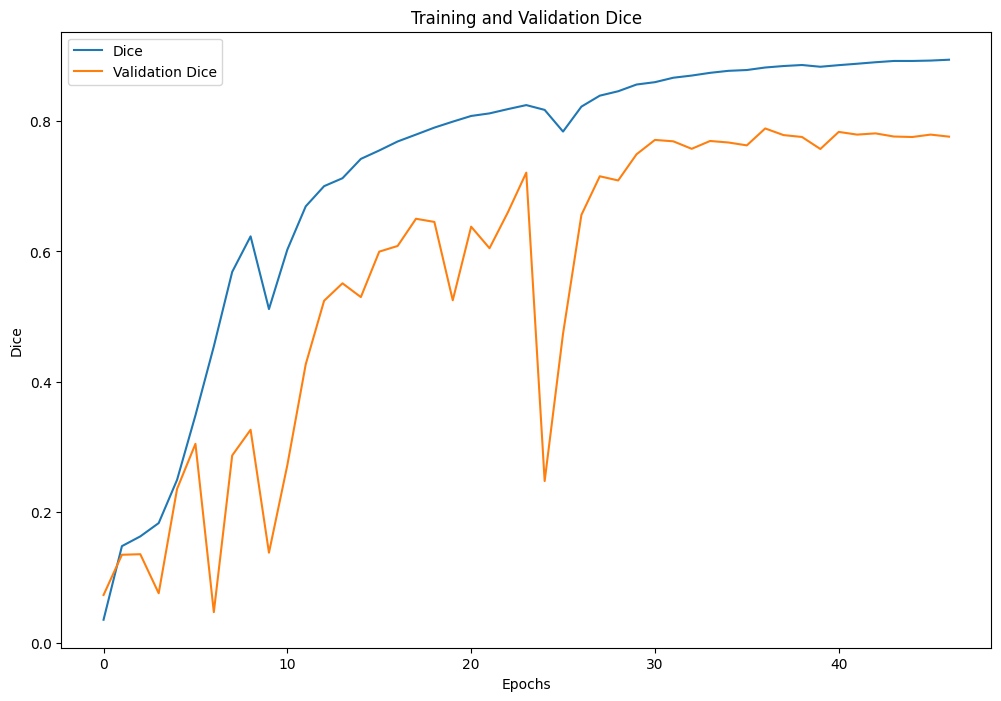

In [149]:
epochs = range(len(history1.history['accuracy']))

delta = np.array(history1.history['dice_coeff']) - np.array(history1.history['val_dice_coeff'])

print(np.argmin(delta))
# Plot accuracy
plt.figure(figsize=(12, 8))
# plt.plot(epochs, delta)
plt.plot(epochs, history1.history['dice_coeff'], label='Dice')
plt.plot(epochs, history1.history['val_dice_coeff'], label='Validation Dice')
plt.title('Training and Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

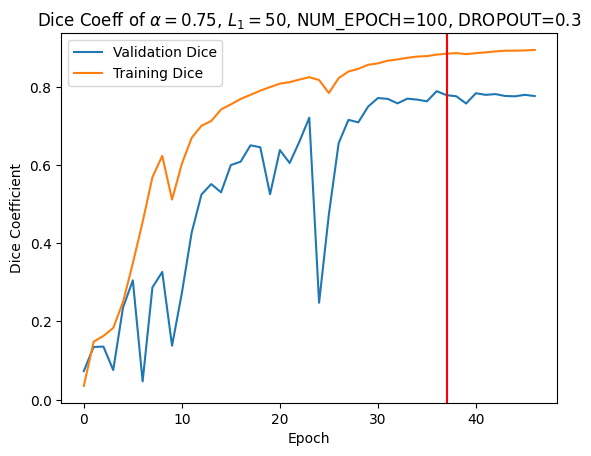

In [159]:
import pandas as pd

df = pd.read_csv("model1_100epoch_dropout_nobed.csv")

plt.plot(df["epoch"], df["val_dice_coeff"], label="Validation Dice")
plt.plot(df["epoch"], df["dice_coeff"], label="Training Dice")
plt.axvline(x=37, color='red')

plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient")
plt.title(r"Dice Coeff of $\alpha = 0.75$, $L_1=50$, NUM_EPOCH=100, DROPOUT=0.3")

plt.legend()
plt.show()

## Model Predictions

In [151]:
custom_objects = {
    'custom_loss1': custom_loss1,
    'dice_coeff': dice_coeff,
    'rand_index': rand_index,
    'jaccard_index': jaccard_index,
    'specificity': specificity
}

loaded_model = tf.keras.models.load_model("./model1_100epoch_dropout_nobed.keras", custom_objects=custom_objects)

In [152]:
test_images = []
test_masks = []

for image, mask in test_dataset:
    test_images.append(image.numpy())
    test_masks.append(mask.numpy())

all_test_images = np.concatenate(test_images, axis=0)
all_test_masks = np.concatenate(test_masks, axis=0)

# for i in range(len(test_images)):
#     img = test_images[i]

predictions = loaded_model.predict(all_test_images)

10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 956ms/step


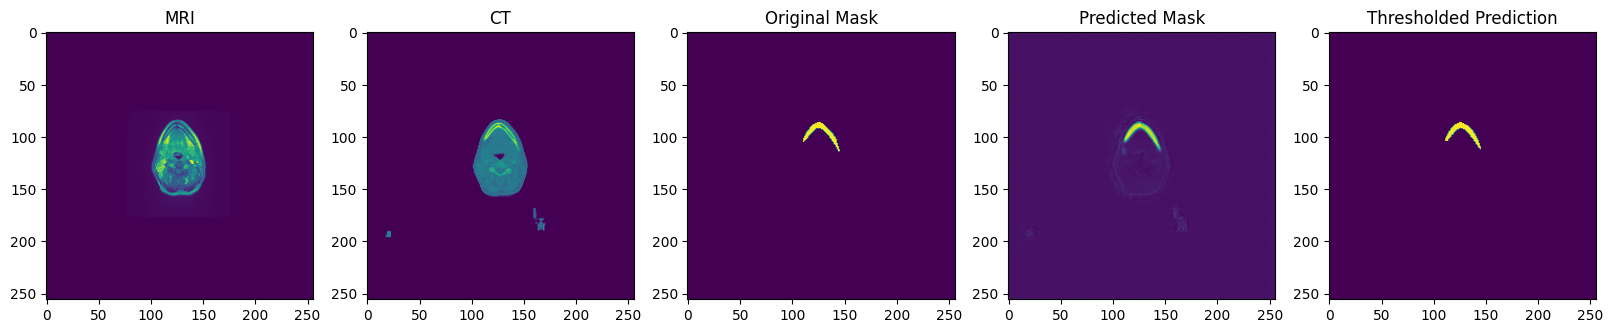

In [158]:
# PLAY AROUND WITH IDX TO SEE DIFFERENT SEGMENTS
idx = 50

img = all_test_images[idx]
test_img_mri = img[:, :, 0]
test_img_ct = img[:, :, 1]
test_img_mask = all_test_masks[idx]
pred_mask = predictions[idx]
pred_mask_thresholded = pred_mask > 0.5

plt.figure(figsize=(20, 12))

plt.subplot(1, 5, 1)
plt.title('MRI')
plt.imshow(test_img_mri)

plt.subplot(1, 5, 2)
plt.title('CT')
plt.imshow(test_img_ct)

plt.subplot(1, 5, 3)
plt.title('Original Mask')
plt.imshow(test_img_mask)

plt.subplot(1, 5, 4)
plt.title('Predicted Mask')
plt.imshow(pred_mask)

plt.subplot(1, 5, 5)
plt.title('Thresholded Prediction')
plt.imshow(pred_mask_thresholded)
